In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE





In [2]:
import chromadb
import pandas as pd
import numpy as np

client = chromadb.PersistentClient(path="../VektorDatenBank_Gesetze")
collection = client.get_collection("VektorDatenBank_Gesetze")

# alles auslesen
data = collection.get(include=["embeddings", "metadatas", "documents"])

df = pd.DataFrame({
    'id': data['ids'],
    'document': data['documents'],
    'embedding': [list(emb) for emb in data['embeddings']],  # Jedes Embedding als Liste
    'gesetz': [m.get('gesetz', '') for m in data['metadatas']]
})

print(f"Anzahl der Embeddings: {len(df)}")
print(df.head())


Anzahl der Embeddings: 125
        id                                           document  \
0  chunk_0  Allgemeines Gleichbehandlungsgesetz\n\nZiel de...   
1  chunk_1  nerwünschte sexuelle Handlungen und Aufforderu...   
2  chunk_2  § 1 genannten Grundes besondere Schutzvorschri...   
3  chunk_3  losengeld, rentenberechtigt sind.\n\nEin Arbei...   
4  chunk_4  te von der Benachteiligung Kenntnis erlangt.\n...   

                                           embedding gesetz  
0  [0.005774340126663446, -0.11959856003522873, 0...    AGG  
1  [-0.057273510843515396, 0.014118099585175514, ...    AGG  
2  [-0.02023337036371231, 0.015834510326385498, 0...    AGG  
3  [-0.06675133109092712, -0.01510631013661623, 0...    AGG  
4  [-0.014707460068166256, -0.010855619795620441,...    AGG  


In [3]:
df.isnull().sum()

id           0
document     0
embedding    0
gesetz       0
dtype: int64

In [4]:
embeddings_matrix = np.array(data['embeddings'])
print(embeddings_matrix.shape)
embeddings_matrix[0:5][:5]  # Zeige die ersten 5 Werte des ersten Embeddings



(125, 1024)


array([[ 0.00577434, -0.11959856,  0.05049924, ..., -0.01729665,
        -0.01394677, -0.03859045],
       [-0.05727351,  0.0141181 ,  0.05315702, ...,  0.00843156,
        -0.00021458, -0.01623109],
       [-0.02023337,  0.01583451,  0.0160605 , ...,  0.00382662,
         0.02329143,  0.00350076],
       [-0.06675133, -0.01510631,  0.0086442 , ...,  0.00362907,
         0.0212333 , -0.03215329],
       [-0.01470746, -0.01085562, -0.00573961, ..., -0.02193858,
         0.01977089, -0.00171068]], shape=(5, 1024))

In [9]:
df.head(  )

,id,document,embedding,gesetz,tsne_x,tsne_y
0,chunk_0,Allgemeines Gleichbehandlungsgesetz\n\nZiel de...,"[0.005774340126663446, -0.11959856003522873, 0...",AGG,-4.645512,2.412714
1,chunk_1,nerwünschte sexuelle Handlungen und Aufforderu...,"[-0.057273510843515396, 0.014118099585175514, ...",AGG,-3.463475,3.813902
2,chunk_2,§ 1 genannten Grundes besondere Schutzvorschri...,"[-0.02023337036371231, 0.015834510326385498, 0...",AGG,-3.016137,3.918807
3,chunk_3,"losengeld, rentenberechtigt sind.\n\nEin Arbei...","[-0.06675133109092712, -0.01510631013661623, 0...",AGG,-2.428219,4.697367
4,chunk_4,te von der Benachteiligung Kenntnis erlangt.\n...,"[-0.014707460068166256, -0.010855619795620441,...",AGG,-3.089502,5.730752


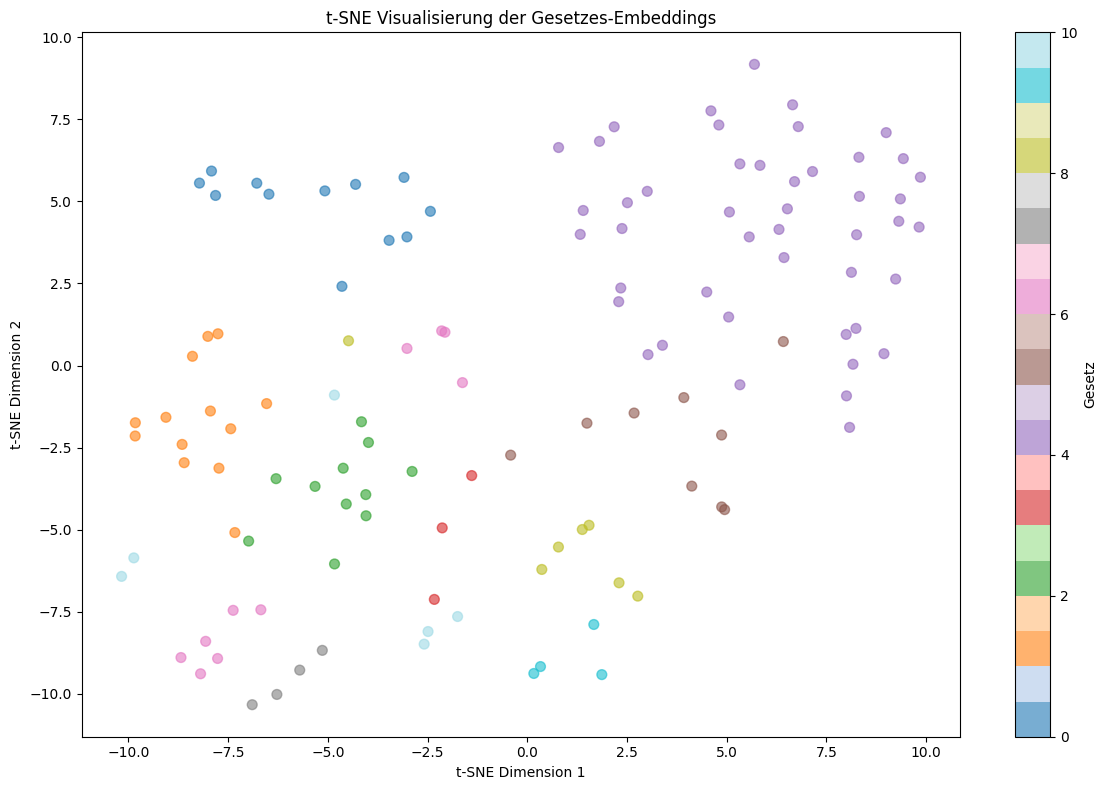

In [5]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_matrix)

# Zum DataFrame hinzufügen
df['tsne_x'] = embeddings_2d[:, 0]
df['tsne_y'] = embeddings_2d[:, 1]

# Visualisierung
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['tsne_x'], df['tsne_y'], 
                     c=pd.Categorical(df['gesetz']).codes,
                     cmap='tab20', alpha=0.6, s=50)
plt.colorbar(scatter, label='Gesetz')
plt.title('t-SNE Visualisierung der Gesetzes-Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

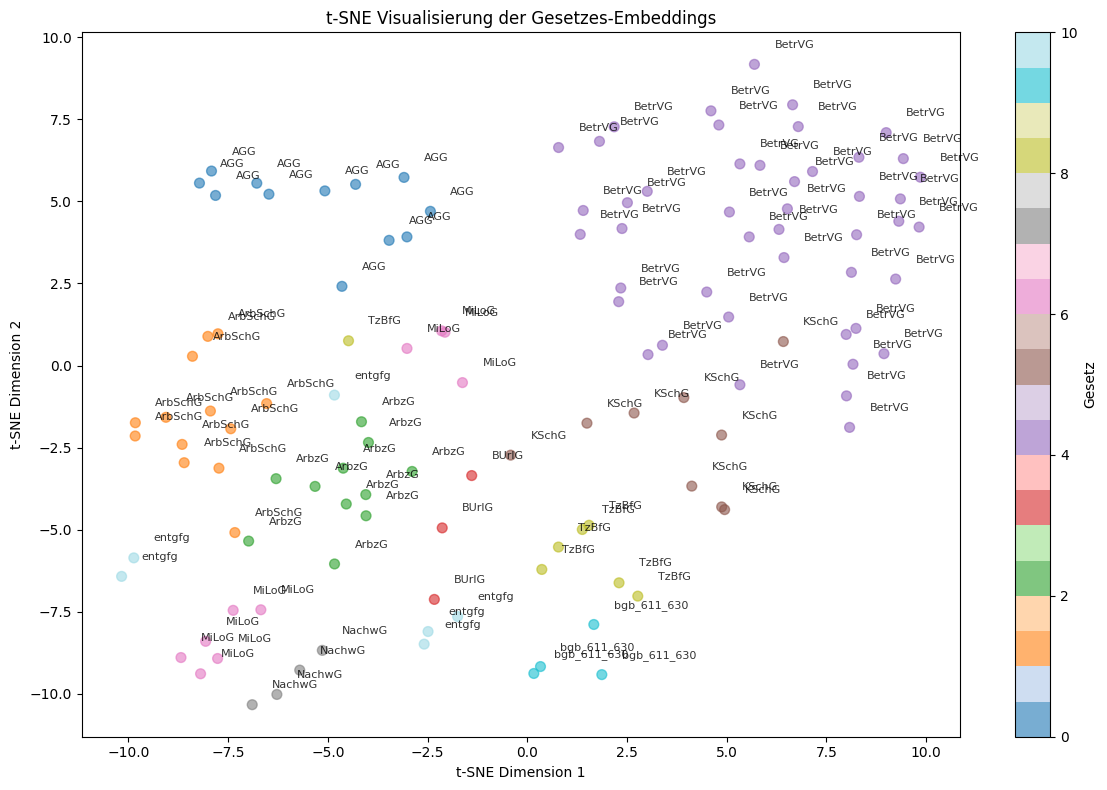

In [12]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_matrix)

df['tsne_x'] = embeddings_2d[:, 0]
df['tsne_y'] = embeddings_2d[:, 1]

plt.figure(figsize=(12, 8))

# Farben pro Gesetz
colors = pd.Categorical(df['gesetz']).codes
scatter = plt.scatter(df['tsne_x'], df['tsne_y'], 
                      c=colors,
                      cmap='tab20',
                      alpha=0.6, s=50)

# Textlabels hinzufügen
for i, row in df.iterrows():
    plt.text(row['tsne_x'] + 0.5, row['tsne_y'] + 0.5,
             row['gesetz'],
             fontsize=8, alpha=0.8)

plt.colorbar(scatter, label='Gesetz')
plt.title('t-SNE Visualisierung der Gesetzes-Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()


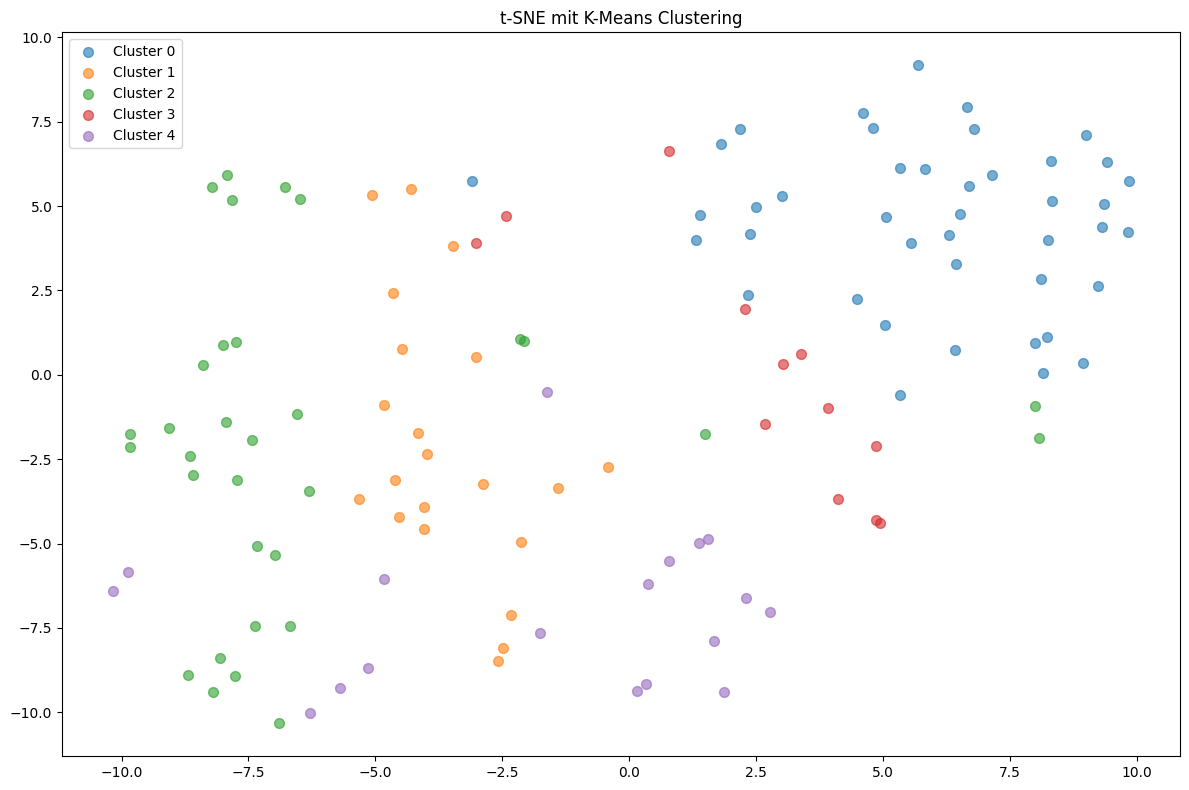


=== Cluster 0 ===
Anzahl Dokumente: 42
Häufigste Gesetze:
gesetz
BetrVG    40
AGG        1
KSchG      1
Name: count, dtype: int64

=== Cluster 1 ===
Anzahl Dokumente: 21
Häufigste Gesetze:
gesetz
ArbzG     8
AGG       4
BUrlG     3
entgfg    3
KSchG     1
Name: count, dtype: int64

=== Cluster 2 ===
Anzahl Dokumente: 32
Häufigste Gesetze:
gesetz
ArbSchG    13
MiLoG       8
AGG         5
ArbzG       2
BetrVG      2
Name: count, dtype: int64

=== Cluster 3 ===
Anzahl Dokumente: 12
Häufigste Gesetze:
gesetz
KSchG     6
BetrVG    4
AGG       2
Name: count, dtype: int64

=== Cluster 4 ===
Anzahl Dokumente: 18
Häufigste Gesetze:
gesetz
TzBfG          6
bgb_611_630    4
entgfg         3
NachwG         3
ArbzG          1
Name: count, dtype: int64


In [ ]:
# K-Means Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_matrix)

# Visualisierung mit Clustern
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
               label=f'Cluster {cluster}', alpha=0.6, s=50)
plt.legend()
plt.title('t-SNE mit K-Means Clustering')
plt.tight_layout()
plt.show()

# Cluster-Analyse: Häufigste Gesetze pro Cluster
for cluster in range(n_clusters):
    print(f"\n=== Cluster {cluster} ===")
    cluster_docs = df[df['cluster'] == cluster]
    print(f"Anzahl Dokumente: {len(cluster_docs)}")
    print("Häufigste Gesetze:")
    print(cluster_docs['gesetz'].value_counts().head(5))

ValueError: Per-column arrays must each be 1-dimensional

In [8]:
df.document.unique()

array(['Allgemeines Gleichbehandlungsgesetz\n\nZiel des Gesetzes ist, Benachteiligungen aus Gründen der Rasse oder wegen der ethnischen Herkunft, des Geschlechts, der Religion oder Weltanschauung, einer Behinderung, des Alters oder der sexuellen Identität zu verhindern oder zu beseitigen.\n\n(1) Benachteiligungen aus einem in § 1 genannten Grund sind nach Maßgabe dieses Gesetzes unzulässig in Bezug auf:\n1.\ndie Bedingungen, einschließlich Auswahlkriterien und Einstellungsbedingungen, für den Zugang zu unselbstständiger und selbstständiger Erwerbstätigkeit, unabhängig von Tätigkeitsfeld und beruflicher Position, sowie für den beruflichen Aufstieg,\n2.\ndie Beschäftigungs- und Arbeitsbedingungen einschließlich Arbeitsentgelt und Entlassungsbedingungen, insbesondere in individual- und kollektivrechtlichen Vereinbarungen und Maßnahmen bei der Durchführung und Beendigung eines Beschäftigungsverhältnisses sowie beim beruflichen Aufstieg,\n3.\nden Zugang zu allen Formen und allen Ebenen der 

In [13]:
df.gesetz.unique()

array(['AGG', 'ArbSchG', 'ArbzG', 'BetrVG', 'BUrlG', 'bgb_611_630',
       'entgfg', 'KSchG', 'MiLoG', 'NachwG', 'TzBfG'], dtype=object)

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    v1 = np.array(vec1)
    v2 = np.array(vec2)
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
#

In [15]:
def find_similar_documents(df, doc_id, top_k=5):
    # Embedding des Ziel-Dokuments
    target_embedding = df.loc[df['id'] == doc_id, 'embedding'].iloc[0]
    
    similarities = []

    for idx, row in df.iterrows():
        sim = cosine_similarity(target_embedding, row['embedding'])
        similarities.append(sim)

    df['similarity'] = similarities

    # sortiert nach Ähnlichkeit, ohne das Dokument selbst
    return df[df['id'] != doc_id].sort_values(by="similarity", ascending=False).head(top_k)



In [17]:
df.head()

,id,document,embedding,gesetz,tsne_x,tsne_y
0,chunk_0,Allgemeines Gleichbehandlungsgesetz\n\nZiel de...,"[0.005774340126663446, -0.11959856003522873, 0...",AGG,-4.645512,2.412714
1,chunk_1,nerwünschte sexuelle Handlungen und Aufforderu...,"[-0.057273510843515396, 0.014118099585175514, ...",AGG,-3.463475,3.813902
2,chunk_2,§ 1 genannten Grundes besondere Schutzvorschri...,"[-0.02023337036371231, 0.015834510326385498, 0...",AGG,-3.016137,3.918807
3,chunk_3,"losengeld, rentenberechtigt sind.\n\nEin Arbei...","[-0.06675133109092712, -0.01510631013661623, 0...",AGG,-2.428219,4.697367
4,chunk_4,te von der Benachteiligung Kenntnis erlangt.\n...,"[-0.014707460068166256, -0.010855619795620441,...",AGG,-3.089502,5.730752


In [16]:
find_similar_documents(df, doc_id="BGB_123", top_k=10)


IndexError: single positional indexer is out-of-bounds